# Movie Recommend System Based on MovieLens 20M Dataset
### Note:
This code is just an exercise.  
Due to the shortage of time, there are many shortcomings in it.  


In [1]:
%matplotlib inline
import os
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
DATA_SET_NAME = 'ml-20m'
DATA_PATH = './data'

# 1. Download MovieLens 20M Dataset
The data will be download to this path: "**./data**" and unzip automatically.

In [1]:
from urllib.request import urlretrieve
from tqdm import tqdm
import zipfile

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

        
def download_extract():
    """
    Download and extract database
    """
    url = 'http://files.grouplens.org/datasets/movielens/' + DATA_SET_NAME + '.zip'
    
    if not os.path.exists(DATA_PATH):
        os.makedirs(DATA_PATH)
    
    file_path = os.path.join(DATA_PATH, DATA_SET_NAME + '.zip')
    
    # download data:
    if not os.path.exists(file_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading ml-20m.zip') as pbar:
            urlretrieve(
                url,
                file_path,
                pbar.hook)
    else:
        return
    
    print('Extracting data...')
    with zipfile.ZipFile(file_path) as zf:
        zf.extractall(DATA_PATH)

    print('Done.')

#-------------------------------------------------------
download_extract()

Extracting data...
Done.


# 2. Load and Preview Data
&ensp;&ensp;Load data and preview the data at the beginning.
There are six csv files in the dataset: `links.csv`, `movies.csv`, `ratings.csv`, `tags.csv`, `genome-tags.csv`, `genome-scores.csv`.

In [16]:
print('movies.csv: ')
movies = pd.read_csv(os.path.join(DATA_PATH, DATA_SET_NAME,'movies.csv'),index_col=None)
movies.describe()
movies.head(5)

movies.csv: 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [46]:
print('ratings.csv: ')
ratings = pd.read_csv(os.path.join(DATA_PATH, DATA_SET_NAME,'ratings.csv'),index_col=None)
ratings.describe()
ratings.head(5)

ratings.csv: 


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [4]:
print('tags.csv: ')
tags = pd.read_csv(os.path.join(DATA_PATH, DATA_SET_NAME,'tags.csv'),index_col=None)
tags.describe()
tags.head(5)

tags.csv: 


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [5]:
print('genome-tags.csv: ')
genome_tags = pd.read_csv(os.path.join(DATA_PATH, DATA_SET_NAME,'genome-tags.csv'),index_col=None)
genome_tags.describe()
genome_tags.head(5)

genome-tags.csv: 


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [6]:
print('genome-scores.csv: ')
genome_scores = pd.read_csv(os.path.join(DATA_PATH, DATA_SET_NAME,'genome-scores.csv'),index_col=None)
genome_scores.describe()
genome_scores.head(5)

genome-scores.csv: 


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


# 3. Simple Statistics
Do simple Statistics and it will help us understand the data better.

In [61]:
print('The number of movies: {}'.format(movies.count()['movieId']))
print('The number of ratings: {}'.format(ratings.count()['movieId']))

print('')
print('min value of rating: {}'.format(ratings['rating'].min()))
print('max value of rating: {}'.format(ratings['rating'].max()))

print('')
ra = ratings.groupby(ratings['userId']).count()
print('The number of user in ratings.csv: {}'.format(ra.count()[0]))
print('The minimum number of ratings per user in ratings.csv: {}'.format(ra['movieId'].min()))
print('The maximun number of ratings per user in ratings.csv: {}'.format(ra['movieId'].max()))

print('')
ra = ratings.groupby(ratings['movieId']).count()
print('The number of movies in ratings.csv: {}'.format(ra.count()[0]))
print('The minimum number of ratings per movie in ratings.csv: {}'.format(ra['userId'].min()))
print('The maximun number of ratings per movie in ratings.csv: {}'.format(ra['userId'].max()))

The number of movies: 27278
The number of ratings: 20000263

min value of rating: 0.5
max value of rating: 5.0

The number of user in ratings.csv: 138493
The minimum number of ratings per user in ratings.csv: 20
The maximun number of ratings per user in ratings.csv: 9254

The number of movies in ratings.csv: 26744
The minimum number of ratings per movie in ratings.csv: 1
The maximun number of ratings per movie in ratings.csv: 67310


In [58]:
print('The number of tags in tags.csv: {}'.format(tags.count()['userId']))
print('The number of tags in genome-tags.csv: {}'.format(genome_tags.count()['tagId']))

print('')
ra = tags.groupby(tags['userId']).count()
print('The number of user in tags.csv: {}'.format(ra.count()[0]))
print('The minimum number of tags per user in tags.csv: {}'.format(ra['movieId'].min()))
print('The maximun number of tags per user in tags.csv: {}'.format(ra['movieId'].max()))

print('')
ra = tags.groupby(tags['movieId']).count()
print('The number of movies in tags.csv: {}'.format(ra.count()[0]))
print('The minimum number of tags per movie in tags.csv: {}'.format(ra['userId'].min()))
print('The maximun number of tags per movie in tags.csv: {}'.format(ra['userId'].max()))

print('')
tags_mer = pd.merge(tags, genome_tags, how='left', left_on='tag', right_on='tag')
print('The number of tags in tags.csv but not in genome-tags.csv: {}'.format(tags_mer[(tags_mer['tagId'].isnull())].count()[0]))

The number of tags in tags.csv: 465564
The number of tags in genome-tags.csv: 1128

The number of user in tags.csv: 7801
The minimum number of tags per user in tags.csv: 1
The maximun number of tags per user in tags.csv: 20356

The number of movies in tags.csv: 19545
The minimum number of tags per movie in tags.csv: 1
The maximun number of tags per movie in tags.csv: 1994

The number of tags in tags.csv but not in genome-tags.csv: 247993


In [59]:
print('The length of genome_scores.csv: {}'.format(genome_scores.count()['movieId']))
print('max value of relevance from genome_scores.csv: {}'.format(genome_scores['relevance'].max()))
print('min value of relevance from genome_scores.csv: {}'.format(genome_scores['relevance'].min()))

print('')
ra = genome_scores.groupby(genome_scores['movieId']).count()
print('The number of movies in genome_scores.csv: {}'.format(ra.count()[0]))
print('The minimum number of tags per movie in genome_scores.csv: {}'.format(ra['tagId'].min()))
print('The maximun number of tags per movie in genome_scores.csv: {}'.format(ra['tagId'].max()))

The length of genome_scores.csv: 11709768
max value of relevance from genome_scores.csv: 1.0
min value of relevance from genome_scores.csv: 0.00024999999999997247

The number of movies in genome_scores.csv: 10381
The minimum number of tags per movie in genome_scores.csv: 1128
The maximun number of tags per movie in genome_scores.csv: 1128


In [114]:
# Analysis the relevant data of movies in both genome_scores.csv and ratings.csv:

genome_scores_group = genome_scores.groupby(genome_scores['movieId']).mean()
ratings_group = ratings.groupby(ratings['movieId']).mean()
rat_ge_merge = pd.merge(ratings_group, genome_scores_group, how='inner', left_on='movieId', right_on='movieId')
number = rat_mer.count()[0]
print('Number of movies in both genome_scores.csv and ratings.csv: {}. Take up {}% of ratings.csv'\
      .format(number, round(number/19545*100)))

ratings_genome_merge = pd.merge(ratings, genome_scores_group, how='inner', left_on='movieId', right_on='movieId')
number = ratings_genome_merge.count()[0]
print('Number of ratings where its movieId in genome_scores.csv: {}. Take up {}% of ratings.csv'\
      .format(number, round(number/20000263*100)))

print('')
ra = ratings_genome_merge.groupby(ratings_genome_merge['userId']).count()
number = ra.count()[0]
print('{} users rate the movies appearing in both genome_scores.csv and ratings.csv. Take up {}% of ratings.csv'\
      .format(number, round(number/138493*100)))
print('Minimum number of ratings per user for the movies appearing in both genome_scores.csv and ratings.csv: {}'.format(ra['movieId'].min()))

Number of movies in both genome_scores.csv and ratings.csv: 10370. Take up 53.0% of ratings.csv
Number of ratings where its movieId in genome_scores.csv: 19800443. Take up 99.0% of ratings.csv

138493 users rate the movies appearing in both genome_scores.csv and ratings.csv. Take up 100.0% of ratings.csv
Minimum number of ratings per user for the movies appearing in both genome_scores.csv and ratings.csv: 13


# 4. Assumption and Machine Learning Model
## 4.1 Assumption
To simplify the problem, the following assumptions are proposed:  
1. The tags in `genome-tags.csv` are the complete set of tags vector spaces. Other tags not in `genome-tags.csv`  are linear combinations of tags in `genome-tags.csv`.  
2. The feature of movies can be perfectly represent by tags in `genome-tags.csv` such as relevance vector in `genome_scores.csv`.  
The relevance vector in `genome_scores.csv` is correct and can represent the feature of movies.  
3. Ignore the quality of movies.  
4. We cannot get other movies information outside the dataset. So we don't use `links.csv`.
5. Release time of movies does not affect.  
6. Timestamp in `ratings.csv: ` and `tags.csv` does not affect.  


## 4.2 Definition Problem

&ensp;&ensp;I choose 19800443 ratings data to build a model to verify our assumption. These 19800443 ratings contain 10370 different movies and 138493 different users. Every movie have a unique relevance vector.  
&ensp;&ensp;So the problem based on these data is: give the user id and movie id, predict the rating of the movie by this user.

## 4.3 Create Training Data
&ensp;&ensp;Split 19800443 rating data (where its movieId in genome_scores.csv) to training set (80%) and test set (20%). We can see the test data include 99.86% users. If you already have the preprocessed data, you can load it from the last code cell in the section.

In [119]:
# Preprocess data (You should run last code cell to get 'ratings_genome_merge')
# The first column of features is userId, the next is movieId.
# The only one column of target is rating.

remove_fields = ['timestamp','tagId','relevance','rating']
target = ratings_genome_merge['rating']
feature = ratings_genome_merge.drop(remove_fields, axis=1)
features = feature.values
target = target.values

genome_scores_dict = {}
for i in range(10381):
    m_id = -1
    vec = []
    for j in range(1128):
        index = j + i * 1128
        if m_id < 0:
            m_id = genome_scores['movieId'][index]
        assert genome_scores['movieId'][index] == m_id
        assert genome_scores['tagId'][index] == j + 1
        vec.append(genome_scores['relevance'][index])
    genome_scores_dict[str(m_id)] = vec

In [25]:
# Actually, using train_test_split in here is not best. 
# The better method should split the data according the userId, which make sure every user is in the test set.
# But here, let us make it easier and quickly ( We have already include 99.86% users).
from sklearn.model_selection import train_test_split
train_features,test_features, train_target, test_target = train_test_split(features,  
                                                           target,  
                                                           test_size = 0.2,  
                                                           random_state = 0)

dict_t = {}
dict_t['userId'] = test_features[:,0]
dict_t['movieId'] = test_features[:,1]
pd_data = pd.DataFrame.from_dict(dict_t)
user_test = pd_data.groupby(pd_data['userId']).count().count()[0]

print('{}% users in test set ({} users)'.format(round(user_test/138493*100, 2), user_test ))

dict_t = {}
dict_t['userId'] = train_features[:,0]
dict_t['movieId'] = train_features[:,1]
pd_data = pd.DataFrame.from_dict(dict_t)
user_train = pd_data.groupby(pd_data['userId']).count().count()[0]

print('{}% users in training set ({} users)'.format(round(user_train/138493*100, 2), user_train ))


99.86% users in test set (138294 users)
100.0% users in training set (138493 users)


In [26]:
# Save preprocess data to './data/verify_assumption.data'
pickle.dump((train_features, test_features, train_target, test_target, genome_scores_dict), open('./data/verify_assumption.data', 'wb'))

In [2]:
# Load preprocess data from './data/verify_assumption.data'
train_features, test_features, train_target, test_target, genome_scores_dict = pickle.load(open('./data/verify_assumption.data', mode='rb'))

## 4.4 Build Model
&ensp;&ensp;If relevance vector in `genome_scores.csv` can represent the movies, we can use it to build a model that predict the rating by the users. And this model shouldn't be much worse than others. Here, give a simple machine learning model:
<img src="Img/model.png"  height="320" width="250">
### Model Parameters

In [ ]:
batch_size = 768  # batch size 
lr = 1e-3         # learning rate
feature_dim = 512 # Dimension of movie or user feature vector
Epoch = 6         # train epoch

### Model 

In [3]:
class Verify_Assumption_Model(nn.Module):
    """The whole model"""
    def __init__(self):
        super(Verify_Assumption_Model, self).__init__()
        self.emb_user = nn.Embedding(138493 + 1, 512, # use ratings['userId'].max()+1 instead of 138493+1 is better
                            padding_idx=0)
        
        self.movie_transfrom = nn.Sequential(
            nn.Linear(1128, 512),
            nn.Tanh(), # activation function can not be the final layer of Sequential. But it can be the first one.
            nn.Linear(512, 512)
        )
    
    def forward(self, userId, movieVector):
        v_user  = self.emb_user(userId)
        v_movie = self.movie_transfrom(movieVector)
        v_user.unsqueeze_(1)
        v_movie.unsqueeze_(2)
        return torch.bmm(v_user,v_movie)

### Train Model

In [4]:
len_train_features = len(train_features)
index = 0
model = Verify_Assumption_Model()
model.cuda()

loss_fn = torch.nn.MSELoss(reduce=False, size_average=False)
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                               lr=lr, weight_decay=0)
losses = {'train':[], 'test':[]}

for epoch_i in range(Epoch):
    index = 0
    while index <= len_train_features:
        index_end = index + batch_size
        if index_end >= len_train_features:
            batch_train = train_features[index:len_train_features]
            batch_train_target = train_target[index:len_train_features]
        else:
            batch_train = train_features[index:index_end]
            batch_train_target = train_target[index:index_end]

        #assert len(batch_train) == len(batch_train_target)

        userId = batch_train[:,0]
        movieId = batch_train[:,1]
        movie_vec = []
        for i in range(len(movieId)):
            movie_vec.append(genome_scores_dict[str(movieId[i])])


        rating = model(torch.tensor(userId, requires_grad = False).cuda(),torch.tensor(movie_vec, requires_grad = False).cuda())
        rating = rating.squeeze_(1).squeeze_(1)
        loss = sum(loss_fn(rating,torch.tensor(batch_train_target,dtype=torch.float32,requires_grad = False).cuda()))

        opt.zero_grad()
        loss.backward()
        losses['train'].append(loss.detach().cpu().numpy())
        opt.step()
        if len(losses['train']) % 500 == 0:
            print('Epoch {:>3} Batch {:>4}/15840354   train_loss = {:.3f}'.format(
                        epoch_i,
                        index,
                        losses['train'][len(losses['train'])-1]))
        index += batch_size
        
    #############################test#############################
    
    len_test_features = len(test_features)
    index = 0

    while index <= len_test_features:
        index_end = index + batch_size
        if index_end >= len_train_features:
            batch_train = test_features[index:len_train_features]
            batch_train_target = test_target[index:len_train_features]
        else:
            batch_train = test_features[index:index_end]
            batch_train_target = test_target[index:index_end]

        #assert len(batch_train) == len(batch_train_target)

        userId = batch_train[:,0]
        movieId = batch_train[:,1]
        movie_vec = []
        for i in range(len(movieId)):
            movie_vec.append(genome_scores_dict[str(movieId[i])])


        rating = model(torch.tensor(userId, requires_grad = False).cuda(),torch.tensor(movie_vec, requires_grad = False).cuda())
        rating = rating.squeeze_(1).squeeze_(1)
        loss = sum(loss_fn(rating,torch.tensor(batch_train_target,dtype=torch.float32,requires_grad = False).cuda()))

        losses['test'].append(loss.detach().cpu().numpy())
        if len(losses['test']) % 500 == 0:
            print('Epoch {:>3} Batch {:>4}/3960089   test_loss = {:.3f}'.format(
                        epoch_i,
                        index,
                        losses['test'][len(losses['test'])-1]))
        index += batch_size

/home/yj/anaconda3/envs/torch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch   0 Batch 383232/15840354   train_loss = 12942.916
Epoch   0 Batch 767232/15840354   train_loss = 7903.710
Epoch   0 Batch 1151232/15840354   train_loss = 5572.569
Epoch   0 Batch 1535232/15840354   train_loss = 2904.491
Epoch   0 Batch 1919232/15840354   train_loss = 2354.743
Epoch   0 Batch 2303232/15840354   train_loss = 1838.493
Epoch   0 Batch 2687232/15840354   train_loss = 1632.287
Epoch   0 Batch 3071232/15840354   train_loss = 1319.965
Epoch   0 Batch 3455232/15840354   train_loss = 1239.193
Epoch   0 Batch 3839232/15840354   train_loss = 1260.753
Epoch   0 Batch 4223232/15840354   train_loss = 1390.432
Epoch   0 Batch 4607232/15840354   train_loss = 1465.220
Epoch   0 Batch 4991232/15840354   train_loss = 1204.264
Epoch   0 Batch 5375232/15840354   train_loss = 1253.578
Epoch   0 Batch 5759232/15840354   train_loss = 1196.916
Epoch   0 Batch 6143232/15840354   train_loss = 1118.606
Epoch   0 Batch 6527232/15840354   train_loss = 1142.375
Epoch   0 Batch 6911232/15840354

Epoch   2 Batch 910080/3960089   test_loss = 936.566
Epoch   2 Batch 1294080/3960089   test_loss = 973.814
Epoch   2 Batch 1678080/3960089   test_loss = 1047.216
Epoch   2 Batch 2062080/3960089   test_loss = 936.333
Epoch   2 Batch 2446080/3960089   test_loss = 1108.641
Epoch   2 Batch 2830080/3960089   test_loss = 1024.219
Epoch   2 Batch 3214080/3960089   test_loss = 1017.021
Epoch   2 Batch 3598080/3960089   test_loss = 1116.570
Epoch   3 Batch 92928/15840354   train_loss = 934.832
Epoch   3 Batch 476928/15840354   train_loss = 911.011
Epoch   3 Batch 860928/15840354   train_loss = 860.665
Epoch   3 Batch 1244928/15840354   train_loss = 966.095
Epoch   3 Batch 1628928/15840354   train_loss = 872.593
Epoch   3 Batch 2012928/15840354   train_loss = 980.391
Epoch   3 Batch 2396928/15840354   train_loss = 943.696
Epoch   3 Batch 2780928/15840354   train_loss = 850.221
Epoch   3 Batch 3164928/15840354   train_loss = 824.010
Epoch   3 Batch 3548928/15840354   train_loss = 956.717
Epoch   

Epoch   5 Batch 13723392/15840354   train_loss = 895.212
Epoch   5 Batch 14107392/15840354   train_loss = 951.245
Epoch   5 Batch 14491392/15840354   train_loss = 850.574
Epoch   5 Batch 14875392/15840354   train_loss = 738.348
Epoch   5 Batch 15259392/15840354   train_loss = 841.624
Epoch   5 Batch 15643392/15840354   train_loss = 844.419
Epoch   5 Batch 164352/3960089   test_loss = 1144.722
Epoch   5 Batch 548352/3960089   test_loss = 1092.105
Epoch   5 Batch 932352/3960089   test_loss = 1323.005
Epoch   5 Batch 1316352/3960089   test_loss = 1199.119
Epoch   5 Batch 1700352/3960089   test_loss = 1199.100
Epoch   5 Batch 2084352/3960089   test_loss = 1233.202
Epoch   5 Batch 2468352/3960089   test_loss = 1113.564
Epoch   5 Batch 2852352/3960089   test_loss = 1134.825
Epoch   5 Batch 3236352/3960089   test_loss = 1235.720
Epoch   5 Batch 3620352/3960089   test_loss = 1093.614


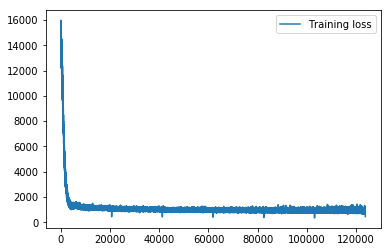

In [7]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

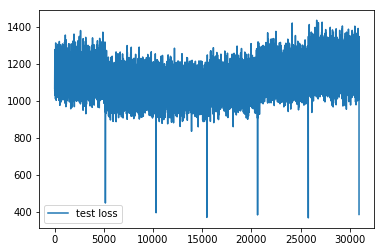

In [8]:
plt.plot(losses['test'], label='test loss')
plt.legend()
_ = plt.ylim()

In [120]:
# Save model to './data/model.pt'
torch.save(model.state_dict(), './data/model.pt')

In [ ]:
# Load model from state_dict file './data/model.pt'
model = Verify_Assumption_Model()
model.load_state_dict(torch.load('./data/model.pt', map_location='cpu'))

## 4.5 Result Analysis and Evaluation
&ensp;&ensp;We can see the test loss slowly descend first and then rise slowly. I think we get a better result by changing the parameters. However, because the training time is too long, there is not enough time to modify different parameters for experiment. I may do it later.  
&ensp;&ensp;Compared with other people's results, such as [chengstone/movie_recommender](https://github.com/chengstone/movie_recommender "With a Title") based on [ml-1m](https://grouplens.org/datasets/movielens/1m/ "With a Title"), our test loss is close. His loss is mean(loss) and here is sum(loss). mean(loss) = sum(loss)/batch_size.  
&ensp;&ensp;So, the performance of this model is good, and it can help us to verify the assumption: relevance vector can represent movies.

# 5 Recommend System
Based on the model in chapter 4, we can build a recommend system that can:  
&ensp;1) Give a list of movies related to a movie;  
&ensp;2) Predict user favourite movies;  
&ensp;3) Recommend relevant movies that user would like and that user have just watched.

## 5.1 Give relevant movies

In [118]:
def get_relevant_movies(id, orginal=True, movie_num=10):
    
    movie_feature = []
    movie_id = []
    movie_num += 1 # because the most relevant movie is the same movie.
    
    # Get all movie vector, You can run quickly if you save the movie vector in your memory.
    for key in genome_scores_dict.keys():
        movie_id.append(key)
        if orginal:     
            norm = np.linalg.norm(genome_scores_dict[key],ord=2) 
            movie_feature.append(genome_scores_dict[key]/norm)
        else:
            v = model.movie_transfrom(torch.tensor(genome_scores_dict[key]).cuda()).cpu().detach().numpy()
            norm = np.linalg.norm(v,ord=2) 
            movie_feature.append(v/norm)

    movie_feature = torch.tensor(movie_feature).unsqueeze_(1).cuda()

    if orginal: 
        norm = np.linalg.norm(genome_scores_dict[str(id)],ord=2)
        in_movie = torch.tensor(genome_scores_dict[str(id)]/norm).expand(10381, 1128).unsqueeze_(2).cuda()
    else:
        v = model.movie_transfrom(torch.tensor(genome_scores_dict[str(id)]).cuda()).cpu().detach().numpy()
        norm = np.linalg.norm(v,ord=2)
        in_movie = torch.tensor(v/norm).cuda().expand(10381, 512).unsqueeze_(2)
    
    similarity = torch.bmm(movie_feature,in_movie).squeeze_(1).squeeze_(1).cpu().detach().numpy()
    index = np.argpartition(similarity, -movie_num)[-movie_num:]
    
    if orginal: 
        print('Find relevant movies based on relevance vector from genome-scores.csv')
    else:
        print('Find relevant movies based on movie feature vector from training model')
    
    print('')
    print('Input Movie: {}'.format(movies[movies['movieId']==id].values[0]))
    print('')
    print('Relevant Movie:')
    
    re = []
    for i in index:
        if movie_id[i] != str(id):
            print('    {}'.format(movies[movies['movieId']==int(movie_id[i])].values[0]))
            re.append(movie_id[i])
            
    return re

### Analysis the result on next code cell
&ensp;&ensp;Here we present the relevant movie search based on the machine learning model and relevance vector from `genome_scores.csv`. We find that both methods can find relevant movies, and there is a certain overlap between the two methods. I think the movie feature vector from model is close to the relevance vector from `genome_scores.csv`.

In [119]:
get_relevant_movies(2,True)
print('')
print('--------------------------------')
print('')
get_relevant_movies(2,False)
pass

Find relevant movies based on relevance vector from genome-scores.csv

Input Movie: [2 'Jumanji (1995)' 'Adventure|Children|Fantasy']

Relevant Movie:
    [2047 'Gnome-Mobile, The (1967)' 'Adventure|Children|Fantasy|Musical']
    [1920 'Small Soldiers (1998)' 'Animation|Children|Fantasy|War']
    [480 'Jurassic Park (1993)' 'Action|Adventure|Sci-Fi|Thriller']
    [7781 'Twister (1990)' 'Comedy']
    [455 'Free Willy (1993)' 'Adventure|Children|Drama']
    [40851 'Zathura (2005)' 'Action|Adventure|Children|Fantasy']
    [2429 'Mighty Joe Young (1998)' 'Action|Adventure|Drama|Fantasy|Thriller']
    [46972 'Night at the Museum (2006)' 'Action|Comedy|Fantasy|IMAX']
    [2054 'Honey, I Shrunk the Kids (1989)'
 'Adventure|Children|Comedy|Fantasy|Sci-Fi']
    [1848 'Borrowers, The (1997)' 'Adventure|Children|Comedy|Fantasy']

--------------------------------

Find relevant movies based on movie feature vector from training model

Input Movie: [2 'Jumanji (1995)' 'Adventure|Children|Fantasy']


## 5.2 Predict User Favourite

In [116]:
def guess_your_favourite(userId, movie_num=10):
    
    user_vector = model.emb_user(torch.tensor([userId]).cuda()).expand(10381, 512).unsqueeze_(2).cuda()
    
    movie_feature = []
    movie_id = []
    for key in genome_scores_dict.keys():
        movie_id.append(key)
        movie_feature.append(model.movie_transfrom(torch.tensor(genome_scores_dict[key]).cuda()).cpu().detach().numpy())

    movie_feature = torch.tensor(movie_feature).unsqueeze_(1).cuda()

    favourite_v = torch.bmm(movie_feature,user_vector).squeeze_(1).squeeze_(1).cpu().detach().numpy()
    index = np.argpartition(favourite_v, -movie_num)[-movie_num:]
    
    
    print('Find your top{} favourite movies'.format(movie_num))
    
    print('')
    print('Favourite Movie:')
    
    re = []
    for i in index:
        if movie_id[i] != str(id):
            print('    {}'.format(movies[movies['movieId']==int(movie_id[i])].values[0]))
            re.append(movie_id[i])
            
    print('')
    print('The rating of these movies by user {}'.format(userId))
    
    for i in re:
        result = ratings[(ratings['movieId']==int(i))&(ratings['userId']==userId)].values
        if len(result) > 0:
            print('    Movie ({:>5}). Rating: {}'.format(i, result[0][2]))
        else:
            print('    There is no rating on this movie ({:>6}) by user.'.format(i))
    return re

### Analysis the result on next code cell
&ensp;&ensp;Looking for the user's favorite movies does not require that users have commented on them. So there will be some movies that have no been rated by this user and some other movies with a relative high scores rated by this user.

In [117]:
guess_your_favourite(7)
pass

Find your top10 favourite movies

Favourite Movie:
    [5952 'Lord of the Rings: The Two Towers, The (2002)' 'Adventure|Fantasy']
    [260 'Star Wars: Episode IV - A New Hope (1977)' 'Action|Adventure|Sci-Fi']
    [1196 'Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Sci-Fi']
    [1200 'Aliens (1986)' 'Action|Adventure|Horror|Sci-Fi']
    [1210 'Star Wars: Episode VI - Return of the Jedi (1983)'
 'Action|Adventure|Sci-Fi']
    [1214 'Alien (1979)' 'Horror|Sci-Fi']
    [109487 'Interstellar (2014)' 'Sci-Fi|IMAX']
    [104841 'Gravity (2013)' 'Action|Sci-Fi|IMAX']
    [79132 'Inception (2010)'
 'Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX']
    [2571 'Matrix, The (1999)' 'Action|Sci-Fi|Thriller']

The rating of these movies by user 7
    There is no rating on this movie (  5952) by user.
    Movie (  260). Rating: 5.0
    Movie ( 1196). Rating: 5.0
    There is no rating on this movie (  1200) by user.
    Movie ( 1210). Rating: 5.0
    There is no rating o

## 5.3 Recommend Movie to User

In [114]:
def recommand_relevant_movies_you_may_like(movieId, userId, movie_num=5):
    
    # The first part code copy from get_relevant_movies
    
    movie_feature = []
    movie_id = []
    
    # Get all movie vector, You can run quickly if you save the movie vector in your memory.
    for key in genome_scores_dict.keys():
        movie_id.append(key)
        norm = np.linalg.norm(genome_scores_dict[key],ord=2) 
        movie_feature.append(genome_scores_dict[key]/norm)

    movie_feature = torch.tensor(movie_feature).unsqueeze_(1).cuda()
 
    norm = np.linalg.norm(genome_scores_dict[str(movieId)],ord=2)
    in_movie = torch.tensor(genome_scores_dict[str(movieId)]/norm).expand(10381, 1128).unsqueeze_(2).cuda()
    
    similarity = torch.bmm(movie_feature,in_movie).squeeze_(1).squeeze_(1).cpu().detach().numpy()
    index = np.argpartition(similarity, -51)[-51:]
    
    re = []
    
    # The Second part code copy from guess_your_favourite
            
    user_vector = model.emb_user(torch.tensor([userId]).cuda()).expand(50, 512).unsqueeze_(2).cuda()
    
    movie_feature = []
    movie_id2 = []
    
    for i in index:
        if movie_id[i] != str(movieId):
            movie_id2.append(movie_id[i])
            movie_feature.append(model.movie_transfrom(torch.tensor(genome_scores_dict[movie_id[i]]).cuda()).cpu().detach().numpy())
            
    movie_feature = torch.tensor(movie_feature).unsqueeze_(1).cuda()

    favourite_v = torch.bmm(movie_feature,user_vector).squeeze_(1).squeeze_(1).cpu().detach().numpy()
    index = np.argpartition(favourite_v, -movie_num)[-movie_num:]
    
    print('Input Movie: {}'.format(movies[movies['movieId']==movieId].values[0]))
    print('User {} may like these {} relevant movies: '.format(userId, movie_num))
    
    print('')
    print('Recommand List:')
    
    re = []
    for i in index:
        if movie_id2[i] != str(id):
            print('    {}'.format(movies[movies['movieId']==int(movie_id2[i])].values[0]))
            re.append(movie_id2[i])
            
    print('')
    print('The rating of these movies by user {}: '.format(userId))
    
    for i in re:
        result = ratings[(ratings['movieId']==int(i))&(ratings['userId']==userId)].values
        if len(result) > 0:
            print('    Movie ({:>3}). Rating: {}'.format(i, result[0][2]))
        else:
            print('    There is no rating on this movie ({:>5}) by user.'.format(i))
            
    return re

### Analysis the result on next code cell
1. we can find that the recommended movies are similar to the input movie.  
2. the recommended movies are not exactly the same as the chapter 5.1 and chapter 5.2. The result of chapter 5.1 base on movie id = 2 and the result of chapter 5.2 base on user id = 7. The result here base on movie id = 2 and user id = 7.  
3. The rating of the recommended movies are relative high.

In [115]:
recommand_relevant_movies_you_may_like(2, 7, movie_num=5)
pass

Input Movie: [2 'Jumanji (1995)' 'Adventure|Children|Fantasy']
User 7 may like these 5 relevant movies: 

Recommand List:
    [653 'Dragonheart (1996)' 'Action|Adventure|Fantasy']
    [480 'Jurassic Park (1993)' 'Action|Adventure|Sci-Fi|Thriller']
    [2617 'Mummy, The (1999)'
 'Action|Adventure|Comedy|Fantasy|Horror|Thriller']
    [40851 'Zathura (2005)' 'Action|Adventure|Children|Fantasy']
    [736 'Twister (1996)' 'Action|Adventure|Romance|Thriller']

The rating of these movies by user 7: 
    There is no rating on this movie (  653) by user.
    Movie (480). Rating: 5.0
    There is no rating on this movie ( 2617) by user.
    There is no rating on this movie (40851) by user.
    Movie (736). Rating: 3.0


# 6 Shortcoming and Future Work
&ensp;&ensp;If use relevance vector from `genome_scores.csv` represent movies, we need more relevance vector since there are only 53.0% movies in the dataset with a relevance vector. So, I think in the future, we can do the following work:  
&ensp;&ensp;&ensp;1) Build a model predit relevance vector for moives. It can be a machine learning model or others such as the [orginal model](http://files.grouplens.org/papers/tag_genome.pdf "With a title").  
&ensp;&ensp;&ensp;2) Predicting user ratings may not be the best way to implement recommendation system. We should try other methods.  
&ensp;&ensp;&ensp;3) Relevance vector may not be the best way to represent a movies. We should also try other methods.  
&ensp;&ensp;&ensp;4) Get more data from internet through `link.csv` to build a model considering the whole reviews from the users.  